In [38]:
### imports

# external modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = False

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [3]:
### Evaluation Parameters

# Select the bias towards recall against precision, treated as a factor (so < 1 biases towards precision, 1 is equal importance, and > 1 biases towards recall)
biasFactor = 20

In [4]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                   "297598":[[-1]],
#                   "297604":[[-1]],   # A decently clean histogram
                   "297620":[[-1]],   # A decently clean histogram
                   "297659":[[-1]],   # An okay histogram
                   "297670":[[-1]],   # A decently clean histogram
#                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
#                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                   "299065":[[-1]],   # A decently clean histogram
                   "299067":[[-1]],   # A decently clean histogram
                   "299096":[[-1]],
                   "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
#                    "299185":[[-1]],   # A decently clean histogram
#                    "299327":[[-1]],
#                    "299329":[[-1]], 
#                    "299480":[[-1]]    # A decently clean histogram
                    },
               '2017C':{
                   "299369":[[-1]]
               },
              '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}

# Select a list of good runs to test on in development training_mode
# Should be validated by eye
goodrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                    "297598":[[-1]],
#                    "297604":[[-1]],   # A decently clean histogram
#                    "297620":[[-1]],   # A decently clean histogram
                    "297659":[[-1]],   # An okay histogram
                    "297670":[[-1]],   # A decently clean histogram
                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                    "299065":[[-1]],   # A decently clean histogram
                    "299067":[[-1]],   # A decently clean histogram
#                    "299096":[[-1]],
#                    "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
                    "299185":[[-1]],   # A decently clean histogram
                    "299327":[[-1]],
#                    "299329":[[-1]], 
                    "299480":[[-1]]    # A decently clean histogram
                    },
              '2017C':{
                  "299368":[[-1]]
              },
              '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017B':
                {
                    #"297048":[[-1]],
                    #"297282":[[-1]],
                    #"297283":[[-1]],
                    #"297284":[[-1]],
                    #"297287":[[-1]],
                    #"297288":[[-1]],
                    #"297289":[[-1]],
                    "299316":[[-1]],
                    "299317":[[-1]],
                    "299318":[[-1]],
                    "299324":[[-1]],
                    "299326":[[-1]],
                    #"301086":[[88,126]],
                    #"301086":[[89,89]],
                    #"303948":[[1710,1710]],
                    "297047":[[-1]], #close but, true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297211":[[-1]], #Reconstructs well
#                   "299325":[[-1]], #Reconstructs well
                    "297664":[[-1]], #true bad for all 8
                    "299317":[[-1]], #true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297502":[[-1]]
                },
             '2017C':{
                 "300781":[[-1]], # bad for tracking (pixels were excluded.
                 "300079":[[-1]], # is bad for strips and then also for tracking
                 "302029":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good 
                 "300576":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
                 "300574":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
                 "300282":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
                 "301912":[[-1]], # Half bad for pixels (lost HV or readout card)  
                 "301086":[[-1]], # Half bad for pixels (lost HV or readout card)  
                 "300283":[[-1]], # Half bad for pixels (lost HV or readout card) 
                 "300282":[[-1]], # Half bad for pixels (lost HV or readout card) 
                 "300281":[[-1]], # Half bad for pixels (lost HV or readout card) 
                 "300239":[[-1]], # Half bad for pixels (lost HV or readout card)
                 "301394":[[-1]], # Marginal for pixels
                 "301183":[[-1]], # Marginal for pixels
                 "300398":[[-1]], # Marginal for pixels
                 "300389":[[-1]], # Marginal for pixels
                 "300365":[[-1]]  # Marginal for pixels
              },
             '2017E':{
                 "304740":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304776":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304506":[[-1]], # Portcard problem for pixels
                 "304507":[[-1]], # Portcard problem for pixels 
                 "303989":[[-1]], # Bad for pixels, power supply died
                 "303824":[[-1]]  # Partly bad for strips due to a test
             },
             '2017F':{
                 "306422":[[-1]], # Partly bad for strips - 2 data readouts failed 
                 "306423":[[-1]], # Partly bad for strips - 2 data readouts failed
                 "306425":[[-1]], # Partly bad for strips - 2 data readouts failed
                 "305440":[[-1]], # Partly bad for strips - 1 data readout failed
                 "305441":[[-1]], # Partly bad for strips - 1 data readout failed
                 "305249":[[-1]], # Bad for pixels - half of disk failed 
                 "305250":[[-1]], # Bad for pixels - half of disk failed
                 "305064":[[-1]], # Marginal for pixels - some readout failed
             },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}


# The year and era being used
year = '2017'
era = 'B'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1', 'adc_PXLayer_1'],
    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2', 'adc_PXLayer_2'],
    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3', 'adc_PXLayer_3'],
    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4', 'adc_PXLayer_4'],
    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [5]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [6]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Evaluate models seperately, as an ensemble, both, or neither
individualEval = True
ensembleEval = False

In [7]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
    # Cherry picked really bad run
    run_application = 299316
    #run_application = 299317
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        offset = 0 # normal case: offset = 0 (just use 5 previous runs)
        
        # Selects the 5 previous runs for training
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
    #runsls_bad = badrunsls[year]
    #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_good = runsls_training
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
    # Select runs to be used in training from the user-defined list
    runsls_training = trainrunsls[year + era]
    # Select bad runs to test on in the user-defined list
    runsls_bad = badrunsls[year + era]
    # Select good runs to test on in the user-defined list
    runsls_good = goodrunsls[year + era]
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'297175': [[-1]], '297620': [[-1]], '297659': [[-1]], '297670': [[-1]], '299065': [[-1]], '299067': [[-1]], '299096': [[-1]], '299149': [[-1]]}
selected runs/lumisections as good test set:
{'297175': [[-1]], '297659': [[-1]], '297670': [[-1]], '297674': [[-1]], '297722': [[-1]], '299065': [[-1]], '299067': [[-1]], '299185': [[-1]], '299327': [[-1]], '299480': [[-1]]}
selected runs/lumisections as bad test set:
{'299316': [[-1]], '299317': [[-1]], '299318': [[-1]], '299324': [[-1]], '299326': [[-1]], '297047': [[-1]], '297169': [[-1]], '297664': [[-1]]}


In [8]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = SubHistStruct.SubHistStruct()
    histstruct.reset_histlist(histnames)
    
    # Unpack histnames and add every histogram individually
    for histnamegroup in histnames:
        for histname in histnamegroup:
            print('Adding {}...'.format(histname))
            
            # Bring the histograms into memory from storage for later use
            filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
            df = dloader.get_dataframe_from_file( filename )
            
            # In case of local training, we can remove most of the histograms
            if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                df = dfu.select_runsls( df, runsls_total )
                
            # Store the data in the histstruct object managing this whole thing
            histstruct.add_dataframe( df, rebinningfactor = 3 )
        
    print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = HistStruct.HistStruct.load('test.pk1')
    
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
if userfriendly:
    print('Created a histstruct with the following properties:')
    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding adc_PXLayer_1...
WARNING in hist_utils.py / rebinhists: no rebinning performed since no suitable reduction factor was given. The rebinning factor (3) is not a divisor of the number of bins (34)
Adding chargeInner_PXLayer_2...
Adding chargeOuter_PXLayer_2...
Adding adc_PXLayer_2...
WARNING in hist_utils.py / rebinhists: no rebinning performed since no suitable reduction factor was given. The rebinning factor (3) is not a divisor of the number of bins (34)
Adding chargeInner_PXLayer_3...
Adding chargeOuter

In [9]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat' )
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

{'299316': [[-1]], '299317': [[-1]], '299318': [[-1]], '299324': [[-1]], '299326': [[-1]], '297047': [[-1]], '297169': [[-1]], '297664': [[-1]]}
Assigned masks: ['dcson', 'golden', 'highstat', 'lowstat', 'training', 'good', 'bad', 'bad0', 'bad1', 'bad2', 'bad3', 'bad4', 'bad5', 'bad6', 'bad7']


In [10]:
### Plotting the input data for analysis

if((training_mode=='local' or training_mode == 'development') and createPlots):

    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )
    
elif( training_mode=='global' and createPlots):
    
    # bad test runs
    for i in [0,1,2,3,4,5,6]:
        histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad{}'.format(i)]],
                                labellist = ['typical good histograms','bad'],
                                colorlist = ['blue','red'],
                                transparencylist = [0.01,1.]
                                    )

In [11]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(256, activation="tanh")(conc_layer)
            encoder = Dense(128, activation='relu')(encoder)
            
            encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(128, activation="relu")(encoder)
            decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [12]:
(histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)


Now Defining model 1/12
 - Size of training set: (1006, 8, 34)
(1006, 8, 34)


2022-06-22 17:42:05.773888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 34)]         0                                            
______________________________________________________________________________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 102)          0           input_12[0][0]                   
                                                                 input_13[0][0]             

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 68)           0           input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 256)          17664       concatenate_7[0][0]        

In [13]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 200
        batch_size = 50
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                                callbacks= [earlystop] 
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)        

In [14]:
train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)


Now training model 1/12


2022-06-22 17:42:07.316657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-22 17:42:07.318828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194915000 Hz


Epoch 1/200
21/21 [==============================] - 4s 45ms/step - loss: 0.0074 - dense_5_loss: 6.1070e-04 - dense_6_loss: 0.0012 - dense_7_loss: 8.5572e-04 - dense_8_loss: 0.0011 - dense_9_loss: 9.2062e-04 - dense_10_loss: 9.1915e-04 - dense_11_loss: 9.7356e-04 - dense_12_loss: 8.6078e-04 - val_loss: 4.9565e-04 - val_dense_5_loss: 4.7082e-05 - val_dense_6_loss: 1.2607e-04 - val_dense_7_loss: 6.8391e-05 - val_dense_8_loss: 4.0370e-05 - val_dense_9_loss: 3.0164e-05 - val_dense_10_loss: 8.3906e-05 - val_dense_11_loss: 6.5975e-05 - val_dense_12_loss: 3.3691e-05
Epoch 2/200
21/21 [==============================] - 0s 10ms/step - loss: 1.9975e-04 - dense_5_loss: 1.9269e-05 - dense_6_loss: 3.9497e-05 - dense_7_loss: 2.3884e-05 - dense_8_loss: 2.7787e-05 - dense_9_loss: 2.1097e-05 - dense_10_loss: 2.9014e-05 - dense_11_loss: 1.9859e-05 - dense_12_loss: 1.9347e-05 - val_loss: 5.8764e-05 - val_dense_5_loss: 4.3986e-06 - val_dense_6_loss: 1.1805e-05 - val_dense_7_loss: 6.8071e-06 - val_dense_8_

21/21 [==============================] - 0s 9ms/step - loss: 1.1751e-05 - dense_5_loss: 5.1597e-07 - dense_6_loss: 3.9493e-06 - dense_7_loss: 5.7267e-07 - dense_8_loss: 2.1035e-06 - dense_9_loss: 9.3436e-07 - dense_10_loss: 1.3477e-06 - dense_11_loss: 9.8952e-07 - dense_12_loss: 1.3379e-06 - val_loss: 1.0904e-05 - val_dense_5_loss: 4.2997e-07 - val_dense_6_loss: 3.6915e-06 - val_dense_7_loss: 5.2617e-07 - val_dense_8_loss: 1.9836e-06 - val_dense_9_loss: 8.9319e-07 - val_dense_10_loss: 1.2367e-06 - val_dense_11_loss: 9.2927e-07 - val_dense_12_loss: 1.2132e-06
Epoch 16/200
21/21 [==============================] - 0s 10ms/step - loss: 1.1675e-05 - dense_5_loss: 5.1250e-07 - dense_6_loss: 3.8850e-06 - dense_7_loss: 5.7276e-07 - dense_8_loss: 2.0905e-06 - dense_9_loss: 9.3574e-07 - dense_10_loss: 1.3412e-06 - dense_11_loss: 1.0003e-06 - dense_12_loss: 1.3375e-06 - val_loss: 1.1033e-05 - val_dense_5_loss: 4.5826e-07 - val_dense_6_loss: 3.6983e-06 - val_dense_7_loss: 5.1931e-07 - val_dense_8_

21/21 [==============================] - 0s 8ms/step - loss: 9.2751e-06 - dense_5_loss: 4.6039e-07 - dense_6_loss: 2.7707e-06 - dense_7_loss: 5.1926e-07 - dense_8_loss: 1.5181e-06 - dense_9_loss: 8.7604e-07 - dense_10_loss: 1.0523e-06 - dense_11_loss: 9.6842e-07 - dense_12_loss: 1.1099e-06 - val_loss: 9.5322e-06 - val_dense_5_loss: 4.9849e-07 - val_dense_6_loss: 2.8330e-06 - val_dense_7_loss: 5.4476e-07 - val_dense_8_loss: 1.5727e-06 - val_dense_9_loss: 9.5852e-07 - val_dense_10_loss: 1.0052e-06 - val_dense_11_loss: 9.8497e-07 - val_dense_12_loss: 1.1345e-06
Epoch 30/200
21/21 [==============================] - 0s 8ms/step - loss: 9.5463e-06 - dense_5_loss: 5.0739e-07 - dense_6_loss: 2.7567e-06 - dense_7_loss: 5.4731e-07 - dense_8_loss: 1.5683e-06 - dense_9_loss: 9.1284e-07 - dense_10_loss: 1.0983e-06 - dense_11_loss: 1.0000e-06 - dense_12_loss: 1.1555e-06 - val_loss: 8.4850e-06 - val_dense_5_loss: 4.4741e-07 - val_dense_6_loss: 2.4370e-06 - val_dense_7_loss: 4.8290e-07 - val_dense_8_l

21/21 [==============================] - 0s 8ms/step - loss: 7.3010e-06 - dense_5_loss: 4.5616e-07 - dense_6_loss: 1.6912e-06 - dense_7_loss: 4.5489e-07 - dense_8_loss: 1.2167e-06 - dense_9_loss: 8.3235e-07 - dense_10_loss: 8.3408e-07 - dense_11_loss: 9.3396e-07 - dense_12_loss: 8.8173e-07 - val_loss: 6.2533e-06 - val_dense_5_loss: 3.6378e-07 - val_dense_6_loss: 1.4473e-06 - val_dense_7_loss: 4.0244e-07 - val_dense_8_loss: 1.0431e-06 - val_dense_9_loss: 7.8950e-07 - val_dense_10_loss: 6.6594e-07 - val_dense_11_loss: 7.9241e-07 - val_dense_12_loss: 7.4880e-07
Epoch 44/200
21/21 [==============================] - 0s 9ms/step - loss: 5.8293e-06 - dense_5_loss: 3.5525e-07 - dense_6_loss: 1.3075e-06 - dense_7_loss: 3.9501e-07 - dense_8_loss: 9.3137e-07 - dense_9_loss: 7.3072e-07 - dense_10_loss: 6.0446e-07 - dense_11_loss: 8.2006e-07 - dense_12_loss: 6.8494e-07 - val_loss: 6.6396e-06 - val_dense_5_loss: 3.4053e-07 - val_dense_6_loss: 1.7519e-06 - val_dense_7_loss: 3.9015e-07 - val_dense_8_l

21/21 [==============================] - 0s 9ms/step - loss: 4.9950e-06 - dense_5_loss: 3.0378e-07 - dense_6_loss: 1.0559e-06 - dense_7_loss: 3.4113e-07 - dense_8_loss: 7.9291e-07 - dense_9_loss: 6.4610e-07 - dense_10_loss: 5.2422e-07 - dense_11_loss: 7.5710e-07 - dense_12_loss: 5.7380e-07 - val_loss: 5.3440e-06 - val_dense_5_loss: 3.2083e-07 - val_dense_6_loss: 1.1493e-06 - val_dense_7_loss: 3.6065e-07 - val_dense_8_loss: 8.7574e-07 - val_dense_9_loss: 7.2280e-07 - val_dense_10_loss: 5.3485e-07 - val_dense_11_loss: 7.6414e-07 - val_dense_12_loss: 6.1566e-07
Epoch 58/200
21/21 [==============================] - 0s 9ms/step - loss: 5.8094e-06 - dense_5_loss: 3.5961e-07 - dense_6_loss: 1.2391e-06 - dense_7_loss: 3.9429e-07 - dense_8_loss: 9.2688e-07 - dense_9_loss: 7.2337e-07 - dense_10_loss: 6.6195e-07 - dense_11_loss: 8.1276e-07 - dense_12_loss: 6.9149e-07 - val_loss: 8.0076e-06 - val_dense_5_loss: 7.6947e-07 - val_dense_6_loss: 1.3819e-06 - val_dense_7_loss: 6.5201e-07 - val_dense_8_l

21/21 [==============================] - 0s 8ms/step - loss: 4.5963e-06 - dense_5_loss: 2.7306e-07 - dense_6_loss: 9.5266e-07 - dense_7_loss: 3.2557e-07 - dense_8_loss: 6.7646e-07 - dense_9_loss: 6.3266e-07 - dense_10_loss: 4.8353e-07 - dense_11_loss: 7.3263e-07 - dense_12_loss: 5.1975e-07 - val_loss: 5.0786e-06 - val_dense_5_loss: 3.0946e-07 - val_dense_6_loss: 1.0699e-06 - val_dense_7_loss: 3.4309e-07 - val_dense_8_loss: 8.2048e-07 - val_dense_9_loss: 6.6842e-07 - val_dense_10_loss: 5.6816e-07 - val_dense_11_loss: 7.3944e-07 - val_dense_12_loss: 5.5969e-07
Epoch 72/200
21/21 [==============================] - 0s 9ms/step - loss: 5.7275e-06 - dense_5_loss: 3.4390e-07 - dense_6_loss: 1.2897e-06 - dense_7_loss: 3.7334e-07 - dense_8_loss: 8.9289e-07 - dense_9_loss: 6.7823e-07 - dense_10_loss: 6.7567e-07 - dense_11_loss: 7.9921e-07 - dense_12_loss: 6.7460e-07 - val_loss: 5.2021e-06 - val_dense_5_loss: 3.4480e-07 - val_dense_6_loss: 1.0667e-06 - val_dense_7_loss: 3.7332e-07 - val_dense_8_l

21/21 [==============================] - 0s 9ms/step - loss: 5.3389e-06 - dense_5_loss: 3.4197e-07 - dense_6_loss: 1.0972e-06 - dense_7_loss: 3.8045e-07 - dense_8_loss: 7.7063e-07 - dense_9_loss: 7.0019e-07 - dense_10_loss: 6.1635e-07 - dense_11_loss: 7.9531e-07 - dense_12_loss: 6.3683e-07 - val_loss: 5.2299e-06 - val_dense_5_loss: 3.0569e-07 - val_dense_6_loss: 1.2510e-06 - val_dense_7_loss: 3.1420e-07 - val_dense_8_loss: 6.8849e-07 - val_dense_9_loss: 7.4736e-07 - val_dense_10_loss: 5.7643e-07 - val_dense_11_loss: 7.4187e-07 - val_dense_12_loss: 6.0486e-07
Epoch 86/200
21/21 [==============================] - 0s 9ms/step - loss: 4.6971e-06 - dense_5_loss: 3.0133e-07 - dense_6_loss: 9.3425e-07 - dense_7_loss: 3.4025e-07 - dense_8_loss: 6.4200e-07 - dense_9_loss: 6.6906e-07 - dense_10_loss: 5.0009e-07 - dense_11_loss: 7.6812e-07 - dense_12_loss: 5.4203e-07 - val_loss: 4.7552e-06 - val_dense_5_loss: 3.0199e-07 - val_dense_6_loss: 9.7839e-07 - val_dense_7_loss: 3.3835e-07 - val_dense_8_l

21/21 [==============================] - 0s 5ms/step - loss: 3.2319e-06 - dense_18_loss: 6.4468e-07 - dense_19_loss: 2.0551e-06 - dense_20_loss: 5.3208e-07 - val_loss: 3.3778e-06 - val_dense_18_loss: 5.9115e-07 - val_dense_19_loss: 2.2855e-06 - val_dense_20_loss: 5.0124e-07
Epoch 18/200
21/21 [==============================] - 0s 5ms/step - loss: 3.1055e-06 - dense_18_loss: 6.4288e-07 - dense_19_loss: 1.9444e-06 - dense_20_loss: 5.1821e-07 - val_loss: 3.8301e-06 - val_dense_18_loss: 6.4189e-07 - val_dense_19_loss: 2.6110e-06 - val_dense_20_loss: 5.7727e-07
Epoch 19/200
21/21 [==============================] - 0s 5ms/step - loss: 3.0192e-06 - dense_18_loss: 6.2229e-07 - dense_19_loss: 1.8363e-06 - dense_20_loss: 5.6061e-07 - val_loss: 3.5532e-06 - val_dense_18_loss: 8.7980e-07 - val_dense_19_loss: 2.0615e-06 - val_dense_20_loss: 6.1191e-07
Epoch 20/200
21/21 [==============================] - 0s 5ms/step - loss: 2.8264e-06 - dense_18_loss: 6.7746e-07 - dense_19_loss: 1.6285e-06 - dense_

21/21 [==============================] - 0s 7ms/step - loss: 1.3093e-06 - dense_18_loss: 4.8440e-07 - dense_19_loss: 5.9847e-07 - dense_20_loss: 2.2643e-07 - val_loss: 1.1275e-06 - val_dense_18_loss: 3.8415e-07 - val_dense_19_loss: 5.0962e-07 - val_dense_20_loss: 2.3369e-07
Epoch 46/200
21/21 [==============================] - 0s 5ms/step - loss: 1.3026e-06 - dense_18_loss: 4.9216e-07 - dense_19_loss: 5.9026e-07 - dense_20_loss: 2.2016e-07 - val_loss: 1.3193e-06 - val_dense_18_loss: 4.2879e-07 - val_dense_19_loss: 6.0770e-07 - val_dense_20_loss: 2.8284e-07
Epoch 47/200
21/21 [==============================] - 0s 5ms/step - loss: 1.1266e-06 - dense_18_loss: 4.3580e-07 - dense_19_loss: 4.6605e-07 - dense_20_loss: 2.2473e-07 - val_loss: 1.2005e-06 - val_dense_18_loss: 4.2554e-07 - val_dense_19_loss: 5.4634e-07 - val_dense_20_loss: 2.2865e-07
Epoch 48/200
21/21 [==============================] - 0s 5ms/step - loss: 9.8940e-07 - dense_18_loss: 3.4895e-07 - dense_19_loss: 4.4862e-07 - dense_

21/21 [==============================] - 0s 6ms/step - loss: 6.0207e-05 - dense_26_loss: 1.3976e-05 - dense_27_loss: 1.4646e-05 - dense_28_loss: 3.1585e-05 - val_loss: 4.8510e-05 - val_dense_26_loss: 1.0918e-05 - val_dense_27_loss: 1.1465e-05 - val_dense_28_loss: 2.6127e-05
Epoch 4/200
21/21 [==============================] - 0s 6ms/step - loss: 4.4499e-05 - dense_26_loss: 1.1529e-05 - dense_27_loss: 1.1325e-05 - dense_28_loss: 2.1645e-05 - val_loss: 3.6479e-05 - val_dense_26_loss: 9.9048e-06 - val_dense_27_loss: 9.2293e-06 - val_dense_28_loss: 1.7345e-05
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 3.1152e-05 - dense_26_loss: 1.0099e-05 - dense_27_loss: 9.1527e-06 - dense_28_loss: 1.1900e-05 - val_loss: 2.1331e-05 - val_dense_26_loss: 8.0073e-06 - val_dense_27_loss: 6.8067e-06 - val_dense_28_loss: 6.5172e-06
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 1.8415e-05 - dense_26_loss: 7.6330e-06 - dense_27_loss: 6.8997e-06 - dense_28_

21/21 [==============================] - 0s 5ms/step - loss: 7.8852e-07 - dense_26_loss: 3.3302e-07 - dense_27_loss: 3.5990e-07 - dense_28_loss: 9.5604e-08 - val_loss: 1.0632e-06 - val_dense_26_loss: 4.2753e-07 - val_dense_27_loss: 4.6084e-07 - val_dense_28_loss: 1.7481e-07
Epoch 32/200
21/21 [==============================] - 0s 6ms/step - loss: 8.0468e-07 - dense_26_loss: 3.4048e-07 - dense_27_loss: 3.6642e-07 - dense_28_loss: 9.7778e-08 - val_loss: 7.4736e-07 - val_dense_26_loss: 3.0859e-07 - val_dense_27_loss: 3.4782e-07 - val_dense_28_loss: 9.0952e-08
Epoch 33/200
21/21 [==============================] - 0s 6ms/step - loss: 7.1954e-07 - dense_26_loss: 3.0304e-07 - dense_27_loss: 3.3816e-07 - dense_28_loss: 7.8331e-08 - val_loss: 7.8122e-07 - val_dense_26_loss: 3.1426e-07 - val_dense_27_loss: 3.7085e-07 - val_dense_28_loss: 9.6115e-08
Epoch 34/200
21/21 [==============================] - 0s 5ms/step - loss: 7.1131e-07 - dense_26_loss: 3.0333e-07 - dense_27_loss: 3.3069e-07 - dense_

21/21 [==============================] - 0s 5ms/step - loss: 1.8603e-06 - dense_34_loss: 6.5750e-07 - dense_35_loss: 5.9252e-07 - dense_36_loss: 6.1028e-07 - val_loss: 1.7845e-06 - val_dense_34_loss: 6.2748e-07 - val_dense_35_loss: 5.4817e-07 - val_dense_36_loss: 6.0886e-07
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 1.7540e-06 - dense_34_loss: 6.1260e-07 - dense_35_loss: 5.4992e-07 - dense_36_loss: 5.9147e-07 - val_loss: 1.7150e-06 - val_dense_34_loss: 6.1976e-07 - val_dense_35_loss: 5.5116e-07 - val_dense_36_loss: 5.4412e-07
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 1.7197e-06 - dense_34_loss: 6.0006e-07 - dense_35_loss: 5.4158e-07 - dense_36_loss: 5.7801e-07 - val_loss: 1.7169e-06 - val_dense_34_loss: 6.1178e-07 - val_dense_35_loss: 5.4353e-07 - val_dense_36_loss: 5.6163e-07
Epoch 10/200
21/21 [==============================] - 0s 6ms/step - loss: 1.7289e-06 - dense_34_loss: 6.0200e-07 - dense_35_loss: 5.3985e-07 - dense_36

21/21 [==============================] - 0s 6ms/step - loss: 4.5163e-06 - dense_42_loss: 1.8928e-06 - dense_43_loss: 1.5561e-06 - dense_44_loss: 1.0673e-06 - val_loss: 2.3925e-06 - val_dense_42_loss: 8.7887e-07 - val_dense_43_loss: 9.2367e-07 - val_dense_44_loss: 5.8995e-07
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 2.1203e-06 - dense_42_loss: 7.5253e-07 - dense_43_loss: 8.2135e-07 - dense_44_loss: 5.4646e-07 - val_loss: 1.8085e-06 - val_dense_42_loss: 6.4177e-07 - val_dense_43_loss: 7.2534e-07 - val_dense_44_loss: 4.4142e-07
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 1.9140e-06 - dense_42_loss: 6.7638e-07 - dense_43_loss: 7.4031e-07 - dense_44_loss: 4.9732e-07 - val_loss: 1.7505e-06 - val_dense_42_loss: 6.2342e-07 - val_dense_43_loss: 6.8999e-07 - val_dense_44_loss: 4.3713e-07
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 1.8710e-06 - dense_42_loss: 6.6075e-07 - dense_43_loss: 7.2400e-07 - dense_44_

Epoch 9/200
21/21 [==============================] - 0s 5ms/step - loss: 6.7905e-06 - dense_50_loss: 5.7084e-06 - dense_51_loss: 1.0820e-06 - val_loss: 4.9458e-06 - val_dense_50_loss: 3.9733e-06 - val_dense_51_loss: 9.7259e-07
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss: 5.8226e-06 - dense_50_loss: 4.6536e-06 - dense_51_loss: 1.1690e-06 - val_loss: 3.9921e-06 - val_dense_50_loss: 2.9746e-06 - val_dense_51_loss: 1.0174e-06
Epoch 11/200
21/21 [==============================] - 0s 5ms/step - loss: 4.6063e-06 - dense_50_loss: 3.3544e-06 - dense_51_loss: 1.2520e-06 - val_loss: 3.0414e-06 - val_dense_50_loss: 2.0428e-06 - val_dense_51_loss: 9.9858e-07
Epoch 12/200
21/21 [==============================] - 0s 5ms/step - loss: 3.1041e-06 - dense_50_loss: 2.0176e-06 - dense_51_loss: 1.0865e-06 - val_loss: 2.1223e-06 - val_dense_50_loss: 1.2614e-06 - val_dense_51_loss: 8.6090e-07
Epoch 13/200
21/21 [==============================] - 0s 5ms/step - loss: 1.9667e-06 - de

21/21 [==============================] - 0s 6ms/step - loss: 3.8455e-05 - dense_57_loss: 1.9623e-05 - dense_58_loss: 1.8833e-05 - val_loss: 1.6276e-05 - val_dense_57_loss: 1.0741e-05 - val_dense_58_loss: 5.5352e-06
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 1.3110e-05 - dense_57_loss: 1.0606e-05 - dense_58_loss: 2.5045e-06 - val_loss: 7.8461e-06 - val_dense_57_loss: 6.8958e-06 - val_dense_58_loss: 9.5032e-07
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 9.8139e-06 - dense_57_loss: 8.9589e-06 - dense_58_loss: 8.5498e-07 - val_loss: 7.4061e-06 - val_dense_57_loss: 6.6749e-06 - val_dense_58_loss: 7.3116e-07
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 9.3414e-06 - dense_57_loss: 8.6073e-06 - dense_58_loss: 7.3409e-07 - val_loss: 7.1051e-06 - val_dense_57_loss: 6.4044e-06 - val_dense_58_loss: 7.0072e-07
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 9.1441e-06 - dense_57_loss: 8.4

21/21 [==============================] - 0s 5ms/step - loss: 7.2628e-07 - dense_57_loss: 3.3791e-07 - dense_58_loss: 3.8837e-07 - val_loss: 7.9924e-07 - val_dense_57_loss: 3.5138e-07 - val_dense_58_loss: 4.4786e-07
Epoch 39/200
21/21 [==============================] - 0s 5ms/step - loss: 7.0910e-07 - dense_57_loss: 3.2759e-07 - dense_58_loss: 3.8151e-07 - val_loss: 8.4532e-07 - val_dense_57_loss: 4.3204e-07 - val_dense_58_loss: 4.1328e-07
Epoch 40/200
21/21 [==============================] - 0s 5ms/step - loss: 7.4800e-07 - dense_57_loss: 3.8020e-07 - dense_58_loss: 3.6780e-07 - val_loss: 7.8381e-07 - val_dense_57_loss: 3.8375e-07 - val_dense_58_loss: 4.0006e-07
Epoch 41/200
21/21 [==============================] - 0s 5ms/step - loss: 6.9522e-07 - dense_57_loss: 3.3178e-07 - dense_58_loss: 3.6344e-07 - val_loss: 7.5402e-07 - val_dense_57_loss: 3.5985e-07 - val_dense_58_loss: 3.9417e-07
Epoch 42/200
21/21 [==============================] - 0s 5ms/step - loss: 7.1287e-07 - dense_57_loss:

21/21 [==============================] - 0s 5ms/step - loss: 1.3066e-06 - dense_64_loss: 6.3370e-07 - dense_65_loss: 6.7286e-07 - val_loss: 1.1551e-06 - val_dense_64_loss: 5.4017e-07 - val_dense_65_loss: 6.1491e-07
Epoch 19/200
21/21 [==============================] - 0s 5ms/step - loss: 1.0860e-06 - dense_64_loss: 5.1351e-07 - dense_65_loss: 5.7250e-07 - val_loss: 1.0516e-06 - val_dense_64_loss: 4.9989e-07 - val_dense_65_loss: 5.5174e-07
Epoch 20/200
21/21 [==============================] - 0s 5ms/step - loss: 1.0054e-06 - dense_64_loss: 4.8791e-07 - dense_65_loss: 5.1748e-07 - val_loss: 1.0017e-06 - val_dense_64_loss: 4.7189e-07 - val_dense_65_loss: 5.2984e-07
Epoch 21/200
21/21 [==============================] - 0s 5ms/step - loss: 9.5692e-07 - dense_64_loss: 4.5824e-07 - dense_65_loss: 4.9868e-07 - val_loss: 1.0581e-06 - val_dense_64_loss: 5.4062e-07 - val_dense_65_loss: 5.1753e-07
Epoch 22/200
21/21 [==============================] - 0s 5ms/step - loss: 9.4519e-07 - dense_64_loss:

21/21 [==============================] - 0s 5ms/step - loss: 6.2829e-06 - dense_71_loss: 5.4971e-06 - dense_72_loss: 7.8583e-07 - val_loss: 4.7875e-06 - val_dense_71_loss: 4.0439e-06 - val_dense_72_loss: 7.4359e-07
Epoch 8/200
21/21 [==============================] - 0s 5ms/step - loss: 5.9988e-06 - dense_71_loss: 5.2152e-06 - dense_72_loss: 7.8359e-07 - val_loss: 4.5363e-06 - val_dense_71_loss: 3.8123e-06 - val_dense_72_loss: 7.2396e-07
Epoch 9/200
21/21 [==============================] - 0s 5ms/step - loss: 5.5495e-06 - dense_71_loss: 4.7806e-06 - dense_72_loss: 7.6887e-07 - val_loss: 4.3582e-06 - val_dense_71_loss: 3.5962e-06 - val_dense_72_loss: 7.6198e-07
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss: 5.0753e-06 - dense_71_loss: 4.2753e-06 - dense_72_loss: 7.9998e-07 - val_loss: 3.7899e-06 - val_dense_71_loss: 3.0285e-06 - val_dense_72_loss: 7.6142e-07
Epoch 11/200
21/21 [==============================] - 0s 5ms/step - loss: 4.3355e-06 - dense_71_loss: 3

21/21 [==============================] - 1s 20ms/step - loss: 0.0012 - dense_78_loss: 7.7906e-04 - dense_79_loss: 4.0929e-04 - val_loss: 4.7525e-05 - val_dense_78_loss: 2.6786e-05 - val_dense_79_loss: 2.0740e-05
Epoch 2/200
21/21 [==============================] - 0s 5ms/step - loss: 3.3118e-05 - dense_78_loss: 1.8220e-05 - dense_79_loss: 1.4898e-05 - val_loss: 1.2612e-05 - val_dense_78_loss: 7.5758e-06 - val_dense_79_loss: 5.0364e-06
Epoch 3/200
21/21 [==============================] - 0s 5ms/step - loss: 8.6818e-06 - dense_78_loss: 6.3027e-06 - dense_79_loss: 2.3791e-06 - val_loss: 5.4141e-06 - val_dense_78_loss: 4.1297e-06 - val_dense_79_loss: 1.2844e-06
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 5.7392e-06 - dense_78_loss: 4.8398e-06 - dense_79_loss: 8.9942e-07 - val_loss: 4.4355e-06 - val_dense_78_loss: 3.6329e-06 - val_dense_79_loss: 8.0263e-07
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 5.4502e-06 - dense_78_loss: 4.7474

21/21 [==============================] - 0s 5ms/step - loss: 1.0653e-06 - dense_78_loss: 5.5492e-07 - dense_79_loss: 5.1042e-07 - val_loss: 1.1009e-06 - val_dense_78_loss: 5.6672e-07 - val_dense_79_loss: 5.3414e-07
Epoch 38/200
21/21 [==============================] - 0s 5ms/step - loss: 1.0179e-06 - dense_78_loss: 5.2162e-07 - dense_79_loss: 4.9632e-07 - val_loss: 1.3069e-06 - val_dense_78_loss: 7.0588e-07 - val_dense_79_loss: 6.0099e-07
Epoch 39/200
21/21 [==============================] - 0s 5ms/step - loss: 1.1360e-06 - dense_78_loss: 5.7638e-07 - dense_79_loss: 5.5959e-07 - val_loss: 1.1051e-06 - val_dense_78_loss: 5.6774e-07 - val_dense_79_loss: 5.3734e-07
Epoch 40/200
21/21 [==============================] - 0s 6ms/step - loss: 1.0259e-06 - dense_78_loss: 5.2720e-07 - dense_79_loss: 4.9867e-07 - val_loss: 1.0909e-06 - val_dense_78_loss: 5.5879e-07 - val_dense_79_loss: 5.3210e-07
Epoch 41/200
21/21 [==============================] - 0s 5ms/step - loss: 1.1016e-06 - dense_78_loss:

Epoch 73/200
21/21 [==============================] - 0s 5ms/step - loss: 9.0841e-07 - dense_78_loss: 5.9977e-07 - dense_79_loss: 3.0864e-07 - val_loss: 7.9998e-07 - val_dense_78_loss: 4.8875e-07 - val_dense_79_loss: 3.1123e-07
Epoch 74/200
21/21 [==============================] - 0s 5ms/step - loss: 8.3199e-07 - dense_78_loss: 5.3751e-07 - dense_79_loss: 2.9448e-07 - val_loss: 1.1585e-06 - val_dense_78_loss: 5.6837e-07 - val_dense_79_loss: 5.9017e-07
Epoch 75/200
21/21 [==============================] - 0s 5ms/step - loss: 8.1900e-07 - dense_78_loss: 5.1049e-07 - dense_79_loss: 3.0851e-07 - val_loss: 9.9763e-07 - val_dense_78_loss: 6.1099e-07 - val_dense_79_loss: 3.8663e-07
Epoch 76/200
21/21 [==============================] - 0s 5ms/step - loss: 8.7390e-07 - dense_78_loss: 5.8473e-07 - dense_79_loss: 2.8917e-07 - val_loss: 8.2222e-07 - val_dense_78_loss: 5.2547e-07 - val_dense_79_loss: 2.9675e-07
Epoch 77/200
21/21 [==============================] - 0s 5ms/step - loss: 7.2991e-07 - d

21/21 [==============================] - 0s 5ms/step - loss: 5.2951e-06 - dense_85_loss: 4.6213e-06 - dense_86_loss: 6.7371e-07 - val_loss: 4.4382e-06 - val_dense_85_loss: 3.7774e-06 - val_dense_86_loss: 6.6080e-07
Epoch 7/200
21/21 [==============================] - 0s 5ms/step - loss: 5.2859e-06 - dense_85_loss: 4.5765e-06 - dense_86_loss: 7.0931e-07 - val_loss: 4.0974e-06 - val_dense_85_loss: 3.3955e-06 - val_dense_86_loss: 7.0187e-07
Epoch 8/200
21/21 [==============================] - 0s 5ms/step - loss: 5.0137e-06 - dense_85_loss: 4.3105e-06 - dense_86_loss: 7.0322e-07 - val_loss: 3.8589e-06 - val_dense_85_loss: 3.1865e-06 - val_dense_86_loss: 6.7240e-07
Epoch 9/200
21/21 [==============================] - 0s 5ms/step - loss: 4.7590e-06 - dense_85_loss: 4.0540e-06 - dense_86_loss: 7.0504e-07 - val_loss: 3.6999e-06 - val_dense_85_loss: 3.0201e-06 - val_dense_86_loss: 6.7983e-07
Epoch 10/200
21/21 [==============================] - 0s 5ms/step - loss: 4.5158e-06 - dense_85_loss: 3.

21/21 [==============================] - 0s 5ms/step - loss: 9.1733e-07 - dense_85_loss: 5.1560e-07 - dense_86_loss: 4.0173e-07 - val_loss: 9.5065e-07 - val_dense_85_loss: 5.1731e-07 - val_dense_86_loss: 4.3334e-07
Epoch 43/200
21/21 [==============================] - 0s 5ms/step - loss: 9.4584e-07 - dense_85_loss: 5.4534e-07 - dense_86_loss: 4.0050e-07 - val_loss: 1.0872e-06 - val_dense_85_loss: 6.1306e-07 - val_dense_86_loss: 4.7415e-07
Epoch 44/200
21/21 [==============================] - 0s 5ms/step - loss: 9.4190e-07 - dense_85_loss: 5.4649e-07 - dense_86_loss: 3.9541e-07 - val_loss: 9.0978e-07 - val_dense_85_loss: 5.1842e-07 - val_dense_86_loss: 3.9136e-07
Epoch 45/200
21/21 [==============================] - 0s 5ms/step - loss: 8.6070e-07 - dense_85_loss: 4.9666e-07 - dense_86_loss: 3.6404e-07 - val_loss: 9.6843e-07 - val_dense_85_loss: 5.7114e-07 - val_dense_86_loss: 3.9729e-07
Epoch 46/200
21/21 [==============================] - 0s 5ms/step - loss: 9.0467e-07 - dense_85_loss:

Epoch 78/200
21/21 [==============================] - 0s 5ms/step - loss: 8.2577e-07 - dense_85_loss: 5.7532e-07 - dense_86_loss: 2.5045e-07 - val_loss: 8.3251e-07 - val_dense_85_loss: 5.9741e-07 - val_dense_86_loss: 2.3510e-07
Epoch 79/200
21/21 [==============================] - 0s 5ms/step - loss: 6.5394e-07 - dense_85_loss: 4.8046e-07 - dense_86_loss: 1.7348e-07 - val_loss: 7.5365e-07 - val_dense_85_loss: 5.4385e-07 - val_dense_86_loss: 2.0981e-07
Epoch 80/200
21/21 [==============================] - 0s 6ms/step - loss: 7.1587e-07 - dense_85_loss: 5.2565e-07 - dense_86_loss: 1.9022e-07 - val_loss: 6.6819e-07 - val_dense_85_loss: 4.5901e-07 - val_dense_86_loss: 2.0919e-07
Epoch 81/200
21/21 [==============================] - 0s 5ms/step - loss: 6.8093e-07 - dense_85_loss: 5.0408e-07 - dense_86_loss: 1.7685e-07 - val_loss: 6.3982e-07 - val_dense_85_loss: 4.8380e-07 - val_dense_86_loss: 1.5602e-07
Epoch 82/200
21/21 [==============================] - 0s 5ms/step - loss: 6.3824e-07 - d

Epoch 9/200
21/21 [==============================] - 0s 9ms/step - loss: 1.1721e-05 - dense_92_loss: 6.3194e-07 - dense_93_loss: 3.0758e-06 - dense_94_loss: 5.7381e-07 - dense_95_loss: 2.2146e-06 - dense_96_loss: 1.0600e-06 - dense_97_loss: 1.5303e-06 - dense_98_loss: 1.1051e-06 - dense_99_loss: 1.5297e-06 - val_loss: 1.0746e-05 - val_dense_92_loss: 5.5221e-07 - val_dense_93_loss: 2.8364e-06 - val_dense_94_loss: 5.1834e-07 - val_dense_95_loss: 2.0158e-06 - val_dense_96_loss: 1.0093e-06 - val_dense_97_loss: 1.3843e-06 - val_dense_98_loss: 1.0653e-06 - val_dense_99_loss: 1.3642e-06
Epoch 10/200
21/21 [==============================] - 0s 9ms/step - loss: 1.4130e-05 - dense_92_loss: 9.5819e-07 - dense_93_loss: 3.3302e-06 - dense_94_loss: 8.8564e-07 - dense_95_loss: 2.5254e-06 - dense_96_loss: 1.3955e-06 - dense_97_loss: 1.8316e-06 - dense_98_loss: 1.3475e-06 - dense_99_loss: 1.8561e-06 - val_loss: 1.1042e-05 - val_dense_92_loss: 5.6401e-07 - val_dense_93_loss: 2.9298e-06 - val_dense_94_lo

21/21 [==============================] - 0s 9ms/step - loss: 1.0978e-05 - dense_92_loss: 5.8574e-07 - dense_93_loss: 2.7844e-06 - dense_94_loss: 5.3816e-07 - dense_95_loss: 2.1316e-06 - dense_96_loss: 1.0459e-06 - dense_97_loss: 1.4225e-06 - dense_98_loss: 1.0806e-06 - dense_99_loss: 1.3892e-06 - val_loss: 1.1148e-05 - val_dense_92_loss: 6.4736e-07 - val_dense_93_loss: 2.6966e-06 - val_dense_94_loss: 6.0690e-07 - val_dense_95_loss: 2.1381e-06 - val_dense_96_loss: 1.1608e-06 - val_dense_97_loss: 1.4161e-06 - val_dense_98_loss: 1.1343e-06 - val_dense_99_loss: 1.3482e-06
Epoch 23/200
21/21 [==============================] - 0s 9ms/step - loss: 1.0945e-05 - dense_92_loss: 5.8846e-07 - dense_93_loss: 2.7626e-06 - dense_94_loss: 5.4416e-07 - dense_95_loss: 2.1169e-06 - dense_96_loss: 1.0484e-06 - dense_97_loss: 1.4288e-06 - dense_98_loss: 1.0766e-06 - dense_99_loss: 1.3797e-06 - val_loss: 1.0260e-05 - val_dense_92_loss: 5.2462e-07 - val_dense_93_loss: 2.5931e-06 - val_dense_94_loss: 5.1831e-

Epoch 36/200
21/21 [==============================] - 0s 8ms/step - loss: 1.0194e-05 - dense_92_loss: 6.1958e-07 - dense_93_loss: 2.3324e-06 - dense_94_loss: 5.4176e-07 - dense_95_loss: 1.9119e-06 - dense_96_loss: 1.0881e-06 - dense_97_loss: 1.3092e-06 - dense_98_loss: 1.0870e-06 - dense_99_loss: 1.3038e-06 - val_loss: 1.0035e-05 - val_dense_92_loss: 6.1430e-07 - val_dense_93_loss: 2.2160e-06 - val_dense_94_loss: 5.8460e-07 - val_dense_95_loss: 1.7713e-06 - val_dense_96_loss: 1.1045e-06 - val_dense_97_loss: 1.3123e-06 - val_dense_98_loss: 1.1477e-06 - val_dense_99_loss: 1.2844e-06
Epoch 37/200
21/21 [==============================] - 0s 8ms/step - loss: 1.1275e-05 - dense_92_loss: 7.8158e-07 - dense_93_loss: 2.3910e-06 - dense_94_loss: 7.0450e-07 - dense_95_loss: 2.0230e-06 - dense_96_loss: 1.2551e-06 - dense_97_loss: 1.4396e-06 - dense_98_loss: 1.2122e-06 - dense_99_loss: 1.4676e-06 - val_loss: 1.1706e-05 - val_dense_92_loss: 7.6454e-07 - val_dense_93_loss: 2.5133e-06 - val_dense_94_l

Epoch 50/200
21/21 [==============================] - 0s 8ms/step - loss: 8.3012e-06 - dense_92_loss: 6.0190e-07 - dense_93_loss: 1.5043e-06 - dense_94_loss: 5.2667e-07 - dense_95_loss: 1.4187e-06 - dense_96_loss: 1.0526e-06 - dense_97_loss: 1.0229e-06 - dense_98_loss: 1.0842e-06 - dense_99_loss: 1.0899e-06 - val_loss: 7.7580e-06 - val_dense_92_loss: 5.4366e-07 - val_dense_93_loss: 1.4081e-06 - val_dense_94_loss: 4.7484e-07 - val_dense_95_loss: 1.3042e-06 - val_dense_96_loss: 1.0024e-06 - val_dense_97_loss: 9.4991e-07 - val_dense_98_loss: 1.0351e-06 - val_dense_99_loss: 1.0398e-06
Epoch 51/200
21/21 [==============================] - 0s 7ms/step - loss: 9.5234e-06 - dense_92_loss: 7.5293e-07 - dense_93_loss: 1.6650e-06 - dense_94_loss: 6.7297e-07 - dense_95_loss: 1.5677e-06 - dense_96_loss: 1.1952e-06 - dense_97_loss: 1.1912e-06 - dense_98_loss: 1.2022e-06 - dense_99_loss: 1.2761e-06 - val_loss: 8.6119e-06 - val_dense_92_loss: 6.3665e-07 - val_dense_93_loss: 1.4829e-06 - val_dense_94_l

Epoch 64/200
21/21 [==============================] - 0s 8ms/step - loss: 6.6585e-06 - dense_92_loss: 4.6908e-07 - dense_93_loss: 9.5111e-07 - dense_94_loss: 4.9981e-07 - dense_95_loss: 9.7093e-07 - dense_96_loss: 9.0824e-07 - dense_97_loss: 8.8061e-07 - dense_98_loss: 9.9899e-07 - dense_99_loss: 9.7972e-07 - val_loss: 6.5469e-06 - val_dense_92_loss: 4.5427e-07 - val_dense_93_loss: 9.0998e-07 - val_dense_94_loss: 4.9508e-07 - val_dense_95_loss: 9.2679e-07 - val_dense_96_loss: 8.8226e-07 - val_dense_97_loss: 8.4507e-07 - val_dense_98_loss: 1.0642e-06 - val_dense_99_loss: 9.6930e-07
Epoch 65/200
21/21 [==============================] - 0s 7ms/step - loss: 6.4888e-06 - dense_92_loss: 4.6290e-07 - dense_93_loss: 9.1525e-07 - dense_94_loss: 4.7313e-07 - dense_95_loss: 9.3833e-07 - dense_96_loss: 8.9026e-07 - dense_97_loss: 8.5034e-07 - dense_98_loss: 9.9966e-07 - dense_99_loss: 9.5890e-07 - val_loss: 7.3133e-06 - val_dense_92_loss: 5.1785e-07 - val_dense_93_loss: 9.5117e-07 - val_dense_94_l

Epoch 78/200
21/21 [==============================] - 0s 8ms/step - loss: 6.0513e-06 - dense_92_loss: 4.3893e-07 - dense_93_loss: 7.5782e-07 - dense_94_loss: 4.8340e-07 - dense_95_loss: 7.9811e-07 - dense_96_loss: 8.7323e-07 - dense_97_loss: 8.2997e-07 - dense_98_loss: 9.7177e-07 - dense_99_loss: 8.9803e-07 - val_loss: 5.4770e-06 - val_dense_92_loss: 3.7904e-07 - val_dense_93_loss: 6.6521e-07 - val_dense_94_loss: 4.2630e-07 - val_dense_95_loss: 6.8882e-07 - val_dense_96_loss: 8.4587e-07 - val_dense_97_loss: 7.5127e-07 - val_dense_98_loss: 9.1710e-07 - val_dense_99_loss: 8.0342e-07
Epoch 79/200
21/21 [==============================] - 0s 8ms/step - loss: 5.6741e-06 - dense_92_loss: 3.9523e-07 - dense_93_loss: 7.1243e-07 - dense_94_loss: 4.3537e-07 - dense_95_loss: 7.5097e-07 - dense_96_loss: 8.4017e-07 - dense_97_loss: 7.7367e-07 - dense_98_loss: 9.2628e-07 - dense_99_loss: 8.3994e-07 - val_loss: 5.7730e-06 - val_dense_92_loss: 3.9659e-07 - val_dense_93_loss: 7.2832e-07 - val_dense_94_l

Epoch 92/200
21/21 [==============================] - 0s 9ms/step - loss: 5.4772e-06 - dense_92_loss: 4.1573e-07 - dense_93_loss: 6.3271e-07 - dense_94_loss: 4.3759e-07 - dense_95_loss: 6.5988e-07 - dense_96_loss: 8.5537e-07 - dense_97_loss: 7.3443e-07 - dense_98_loss: 9.4161e-07 - dense_99_loss: 7.9991e-07 - val_loss: 6.8449e-06 - val_dense_92_loss: 4.8750e-07 - val_dense_93_loss: 8.4732e-07 - val_dense_94_loss: 5.4754e-07 - val_dense_95_loss: 8.9548e-07 - val_dense_96_loss: 9.7502e-07 - val_dense_97_loss: 1.0114e-06 - val_dense_98_loss: 1.1848e-06 - val_dense_99_loss: 8.9587e-07
Epoch 93/200
21/21 [==============================] - 0s 9ms/step - loss: 5.9115e-06 - dense_92_loss: 4.6436e-07 - dense_93_loss: 7.0776e-07 - dense_94_loss: 4.8672e-07 - dense_95_loss: 7.3005e-07 - dense_96_loss: 8.8490e-07 - dense_97_loss: 8.0615e-07 - dense_98_loss: 9.8594e-07 - dense_99_loss: 8.4558e-07 - val_loss: 6.7392e-06 - val_dense_92_loss: 5.0671e-07 - val_dense_93_loss: 9.3749e-07 - val_dense_94_l

Epoch 106/200
21/21 [==============================] - 0s 9ms/step - loss: 6.0849e-06 - dense_92_loss: 4.8852e-07 - dense_93_loss: 7.5258e-07 - dense_94_loss: 5.3021e-07 - dense_95_loss: 7.2159e-07 - dense_96_loss: 9.2998e-07 - dense_97_loss: 7.8388e-07 - dense_98_loss: 1.0147e-06 - dense_99_loss: 8.6346e-07 - val_loss: 5.7252e-06 - val_dense_92_loss: 4.0012e-07 - val_dense_93_loss: 7.4318e-07 - val_dense_94_loss: 4.9769e-07 - val_dense_95_loss: 5.4935e-07 - val_dense_96_loss: 9.1549e-07 - val_dense_97_loss: 8.0890e-07 - val_dense_98_loss: 9.7955e-07 - val_dense_99_loss: 8.3088e-07
Epoch 107/200
21/21 [==============================] - 0s 9ms/step - loss: 5.5350e-06 - dense_92_loss: 4.4624e-07 - dense_93_loss: 5.8964e-07 - dense_94_loss: 5.0021e-07 - dense_95_loss: 6.0886e-07 - dense_96_loss: 8.9998e-07 - dense_97_loss: 7.1543e-07 - dense_98_loss: 9.6345e-07 - dense_99_loss: 8.1124e-07 - val_loss: 5.6960e-06 - val_dense_92_loss: 3.8200e-07 - val_dense_93_loss: 6.5322e-07 - val_dense_94

Epoch 120/200
21/21 [==============================] - 0s 9ms/step - loss: 4.6804e-06 - dense_92_loss: 3.9282e-07 - dense_93_loss: 3.9945e-07 - dense_94_loss: 4.3001e-07 - dense_95_loss: 4.2165e-07 - dense_96_loss: 8.3946e-07 - dense_97_loss: 6.0137e-07 - dense_98_loss: 9.2322e-07 - dense_99_loss: 6.7246e-07 - val_loss: 4.7727e-06 - val_dense_92_loss: 3.8111e-07 - val_dense_93_loss: 3.8183e-07 - val_dense_94_loss: 4.4283e-07 - val_dense_95_loss: 3.4661e-07 - val_dense_96_loss: 9.8485e-07 - val_dense_97_loss: 5.4766e-07 - val_dense_98_loss: 1.0194e-06 - val_dense_99_loss: 6.6838e-07
Epoch 121/200
21/21 [==============================] - 0s 9ms/step - loss: 4.7237e-06 - dense_92_loss: 4.1685e-07 - dense_93_loss: 4.0306e-07 - dense_94_loss: 4.4579e-07 - dense_95_loss: 4.1530e-07 - dense_96_loss: 8.4344e-07 - dense_97_loss: 5.9024e-07 - dense_98_loss: 9.3497e-07 - dense_99_loss: 6.7404e-07 - val_loss: 6.2971e-06 - val_dense_92_loss: 4.2036e-07 - val_dense_93_loss: 8.2057e-07 - val_dense_94

Epoch 134/200
21/21 [==============================] - 0s 9ms/step - loss: 4.6403e-06 - dense_92_loss: 3.9172e-07 - dense_93_loss: 3.9428e-07 - dense_94_loss: 4.2937e-07 - dense_95_loss: 4.2235e-07 - dense_96_loss: 8.3556e-07 - dense_97_loss: 5.7989e-07 - dense_98_loss: 9.2662e-07 - dense_99_loss: 6.6051e-07 - val_loss: 5.0753e-06 - val_dense_92_loss: 3.7250e-07 - val_dense_93_loss: 5.0821e-07 - val_dense_94_loss: 5.0547e-07 - val_dense_95_loss: 4.8532e-07 - val_dense_96_loss: 9.6931e-07 - val_dense_97_loss: 6.3272e-07 - val_dense_98_loss: 8.9161e-07 - val_dense_99_loss: 7.1022e-07
Epoch 135/200
21/21 [==============================] - 0s 9ms/step - loss: 4.8369e-06 - dense_92_loss: 3.8474e-07 - dense_93_loss: 4.5273e-07 - dense_94_loss: 4.3455e-07 - dense_95_loss: 4.8542e-07 - dense_96_loss: 8.4692e-07 - dense_97_loss: 6.4072e-07 - dense_98_loss: 8.9323e-07 - dense_99_loss: 6.9854e-07 - val_loss: 4.3545e-06 - val_dense_92_loss: 3.5376e-07 - val_dense_93_loss: 2.9661e-07 - val_dense_94

In [15]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [16]:
(mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)

evaluating model for NormalizedHitResiduals_TIB__Layer__1
(2831,)
evaluating model for chargeInner_PXLayer_1
(2831,)
evaluating model for chargeInner_PXLayer_2
(2831,)
evaluating model for chargeInner_PXLayer_3
(2831,)
evaluating model for chargeInner_PXLayer_4
(2831,)
evaluating model for charge_PXDisk_+1
(2831,)
evaluating model for charge_PXDisk_-1
(2831,)
evaluating model for charge_PXDisk_+2
(2831,)
evaluating model for charge_PXDisk_-2
(2831,)
evaluating model for charge_PXDisk_+3
(2831,)
evaluating model for charge_PXDisk_-3
(2831,)
evaluating model for NormalizedHitResiduals_TOB__Layer__1
(2831,)
Found mse array for training set of following shape: (1678, 40)
Found mse array for good set of following shape: (1537, 40)
Found mse array for bad set of following shape: (44, 40)
Found mse array for bad set of following shape: (35, 40)
Found mse array for bad set of following shape: (46, 40)
Found mse array for bad set of following shape: (19, 40)
Found mse array for bad set of follo

In [22]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    if training_mode=='global': 
        fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(mse_train, quantiles, 'up')
    else: 
        fitfunc = GaussianKdeFitter.GaussianKdeFitter()
        fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [23]:
fitfunc = fit_mse_distribution(histstruct, mse_train)

In [24]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    return [logprob_good, logprob_bad]

In [25]:
(logprob_good, logprob_bad) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---
length of log prob array: 1537
minimum of log prob: 386.7475072481789
--- bad lumisections ---


/tmp/ipykernel_4518/688802665.py:12: RuntimeWarning: divide by zero encountered in log
  logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]


length of log prob array: 238
maximum of log prob: 409.9382805076541


In [26]:
def evaluate_autoencoder_individual(histstruct):
    
    msewps = []
    for histname in histstruct.histnames:
        
        # Get histograms from histstruct
        X_test_good = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'good']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        X_test_bad = X_test_bad = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'bad']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        # Get each model from the histstruct
        autoencoder = histstruct.get_classifier(histname)
        
        # Getting evaluation criteria
        prediction_test_good = autoencoder.reconstruct(X_test_good)
        mse_test_good = aeu.mseTopNRaw(X_test_good, prediction_test_good, n=10 )
        prediction_test_bad = autoencoder.reconstruct(X_test_bad)
        mse_test_bad = aeu.mseTopNRaw(X_test_bad, prediction_test_bad, n=10 )
        
        if userfriendly:
            print('Average MSE on good set: ' + str(np.mean(mse_test_good)))
            print('Average MSE on bad set: ' + str(np.mean(mse_test_bad)))
        
        if createPlots:
            # Number of plots of each type to generate per model (so nplot * 2 * len(model))
            nplot = 3
            
            # Good examples
            print('Examples of good histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_good)),size=nplot,replace=False)
            for i in randint: 
                histlist = [X_test_good[int(i),:],prediction_test_good[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
            
            # Bad examples
            print('Examples of bad histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_bad)),size=nplot,replace=False)
            for i in randint:
                histlist = [X_test_bad[int(i),:],prediction_test_bad[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
        
        # Attaching the bad histograms as a new set of rows under the good histograms
        validation_data = np.vstack((X_test_good, X_test_bad))
        validation_preds = np.vstack((prediction_test_good, prediction_test_bad))
        # Creating labels to differentiate the data when we go to compare predictions
        #     with actual label
        labels = np.hstack((np.zeros(len(X_test_good)), np.ones(len(X_test_bad))))
        
        # Pick a working point to see 
        msewp = 0.5*(np.mean(mse_test_bad) - np.mean(mse_test_good))
        print("Selected working point: " + str(msewp))
        
        # Get data to pick a good working point for future evaluation
        scores = aeu.mseTop10Raw(validation_data, validation_preds)
        nsig = np.sum(labels)
        nback = np.sum(1-labels)
        
        # Get some metrics for the user
        tp = np.sum(np.where((labels==1) & (scores>msewp),1,0))/nsig
        fp = np.sum(np.where((labels==0) & (scores>msewp),1,0))/nback
        tn = 1-fp
        fn = 1-tp
        
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2*precision*recall) / (precision + recall)
        
        if userfriendly:
            print(accuracy)
            print(precision)
            print(recall)
            print(f1)
        
    return msewps

In [39]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, np.inf))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, -np.inf))
    
    # Getting rid of infinities
    logprob_good[logprob_good > 500] = goodMax
    logprob_bad[logprob_bad < 0] = badMin
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good < badMin] = badMin
    logprob_bad[logprob_bad > goodMax] = goodMax
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(biasFactor + 1)) * (biasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 424
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + biasFactor * biasFactor) * ((precision * recall) / ((biasFactor * biasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

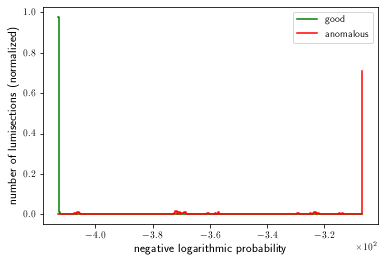

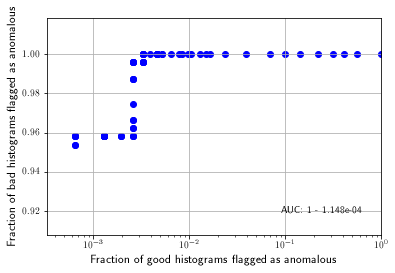

Selected logprob threshold of 408.7107229493794
Accuracy: 0.9962726144459084
Precision: 0.996743820784274
Recall: 0.9957983193277311
F-Measure: 0.9958006749556555


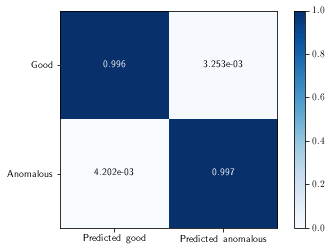

In [40]:
logprob_threshold = evaluate_autoencoders_combined(logprob_good, logprob_bad, biasFactor)

In [ ]:
msewps = evaluate_autoencoder_individual(histstruct)